# Carga dataset curado y librerias NLP

In [1]:
import pandas as pd

path = '../data/processed/sentiment_curated_v1.csv'
df = pd.read_csv(path,)
df.sample(5)

,text,prevision,word_count
2138,Lugar acogedor. El trato ha sido muy bueno por...,Positivo,45
10581,Perfecto para descansar unas horas.. Mi opinió...,Positivo,30
8946,La mejor ubicación. Es una residencia muy agra...,Positivo,42
10128,Hotel familiar . El hotel se encuentra en prim...,Positivo,52
1974,ubicacion perfecta. hotel ccon mucho encanto ...,Positivo,32


La columna `word_count` es extremadamente útil en esta etapa de transición.

1. ¿Por qué conservarla ahora? </br>
Aunque el contrato final solo exige `text` y `prevision`, mantener `word_count` en este momento te sirve para:
- **Control de Calidad:**
Tras aplicar la limpieza de stopwords (palabras vacías), puedes comparar el `word_count` original vs. el nuevo para ver cuánta "paja" eliminaste.
- **Filtro de Seguridad:**
Si después de la limpieza una reseña queda con 0 o 1 palabra, esa fila ya no sirve para entrenar la IA y deberías borrarla.

# Limpieza profunda
El objetivo es que la columna `text` pase de ser "lenguaje humano" a "lenguaje para IA", eliminando todo lo que no ayude a identificar el sentimiento.

## Configuracion de NLTK y Stopwords
Debemos cargar las herramientas de limpieza. </br>
Las stopwords son palabras como "el", "de", "un" que aparecen mucho pero no dicen si una reseña es buena o mala.

In [2]:
import pandas as pd
import re
import string
import nltk
from nltk.corpus import stopwords

# Descargamos el paquete de palabras vacías
nltk.download('stopwords')
stop_words = set(stopwords.words('spanish'))

# Lista de palabras que NO debemos borrar porque cambian el sentido
palabras_a_mantener = {'no', 'ni', 'pero', 'sin', 'nada', 'poco', 'muy'}

# Restamos los conjuntos
stop_words_optimizadas = stop_words - palabras_a_mantener

print(f"Stopwords originales: {len(stop_words)} -> Optimizadas: {len(stop_words_optimizadas)}")

print(f"Librerías cargadas. Tenemos {len(stop_words_optimizadas)} stopwords en español listas para filtrar.")

Stopwords originales: 313 -> Optimizadas: 306
Librerías cargadas. Tenemos 306 stopwords en español listas para filtrar.


[nltk_data] Downloading package stopwords to /home/degops/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Funcion de Limpieza y Normalizacion
Vamos a crear una función que aplique todas las reglas de una vez. </br>
Usaremos la columna `word_count` que trajimos del anterior notebook para comparar el "antes" y el "después".

import re
import string

# Reemplazo completo de la función de limpieza
def limpiar_para_ia(texto):
    # 1. Minúsculas y conversión a string
    texto = str(texto).lower()
    
    # 2. Corregir palabras juntas: Reemplazar puntuación por ESPACIOS
    # Esto evita que "hotel.malo" se convierta en "hotelmalo"
    texto = re.sub(f"[{re.escape(string.punctuation)}]", " ", texto)
    
    # 3. Limpieza de caracteres especiales (Emojis, símbolos como €)
    # Mantenemos solo letras (incluye á, é, í, ó, ú, ñ) y espacios
    texto = re.sub(r'[^a-zñáéíóú\s]', '', texto)
    
    # 4. Quitar Stopwords y palabras residuales (letras sueltas)
    palabras = texto.split()
    palabras_limpias = [w for w in palabras if w not in stop_words and len(w) > 1]
    
    return " ".join(palabras_limpias)

# Ejecutar la limpieza sobre la columna original
df['text_clean'] = df['text'].apply(limpiar_para_ia)

# Actualizar el conteo de palabras para reflejar la nueva limpieza
df['word_count_clean'] = df['text_clean'].apply(lambda x: len(x.split()))

In [3]:
import re
import string

def limpieza_hibrida_optimizada(texto):
    
    # 1. Conversión inicial y URLs
    if not isinstance(texto, str): return ""
    texto = texto.lower()

    # Eliminar URLs antes de tocar la puntuación
    texto = re.sub(r'http\S+|www\S+|https\S+', '', texto, flags=re.MULTILINE)

    # Eliminar menciones y hashtags
    texto = re.sub(r'@\w+|#\w+', '', texto)

    # 2. Corregir palabras juntas 
    # En lugar de borrar todo, primero cambiamos signos de puntuación por espacios
    # Pero OJO: Usamos un regex que NO toque los emojis (rango Unicode)
    puntuacion_a_espacios = re.compile(f"[{re.escape(string.punctuation)}]")
    texto = puntuacion_a_espacios.sub(" ", texto)
    
    # 3. Limpieza de caracteres residuales manteniendo Emojis 
    # Mantenemos: letras, números, espacios y el rango Unicode de emojis
    texto = re.sub(r'[^\w\s\u2600-\u27bf\U0001f300-\U0001f9ff]', '', texto)
    
    # 4. Quitar Stopwords y palabras residuales
    palabras = texto.split()
    
    # stop_words debe estar definida previamente en tu notebook
    palabras_limpias = [w for w in palabras if w not in stop_words_optimizadas and len(w) > 1]
    
    return " ".join(palabras_limpias)

# Ejecutar la limpieza sobre la columna original
df['text_clean'] = df['text'].apply(limpieza_hibrida_optimizada)

# Actualizar el conteo de palabras para reflejar la nueva limpieza
df['word_count_clean'] = df['text_clean'].apply(lambda x: len(x.split()))

#  Optimización del Preprocesamiento: Auditoría

### 5 Muestras de solo la clase Negativa

In [4]:
import pandas as pd

# 1. Configurar para ver el texto completo
pd.set_option('display.max_colwidth', None)

# 2. Tomar 10 muestras aleatorias SIN semilla fija
# Al no tener random_state, cambiarán en cada ejecución
muestras = df[df['prevision'] == 'Negativo'].sample(5)

print(f"🔍 AUDITORÍA DINÁMICA DE LIMPIEZA")
print(f"{'ÍNDICE':<8} | {'SENTIMIENTO':<12} | {'COMPARATIVA'}")
print("-" * 100)

for indice, fila in muestras.iterrows():
    print(f"{indice:<8} | {fila['prevision'].upper():<12} | ORIGINAL: {fila['text'][:120]}...")
    print(f"{'':<8} | {'':<12} | LIMPIO:   {fila['text_clean']}")
    print("-" * 100)

🔍 AUDITORÍA DINÁMICA DE LIMPIEZA
ÍNDICE   | SENTIMIENTO  | COMPARATIVA
----------------------------------------------------------------------------------------------------
3130     | NEGATIVO     | ORIGINAL: No recomendable. Nuestro alojamiento era para pasar una noche durante el viaje en una habitación familiar. Llegamos ya d...
         |              | LIMPIO:   no recomendable alojamiento pasar noche viaje habitación familiar llegamos noche salimos madrugada llegar verlo punto irnos sin entrar pesar tenerlo pagado sólo aspecto dentro igual mal parecía hecho viaje tiempo años 60 habitación sencilla dos edredones doblar apartarlos vimos manchas restos sangre baño bastante limpio perro ladra montón paredes parecen papel noche olvidar deseando irnos no recomiendo absoluto
----------------------------------------------------------------------------------------------------
6887     | NEGATIVO     | ORIGINAL: Hostal céntrico. La atencion por parte del personal y la ubicación, excelente. L

### Reseñas fantasmas

In [5]:
# Ver reseñas que quedaron con 0 o 1 palabra después de la limpieza
reseñas_vacias = df[df['word_count_clean'] <= 1]
print(f"⚠️ Reseñas que quedaron casi vacías: {len(reseñas_vacias)}")
display(reseñas_vacias[['text', 'text_clean']].head())

⚠️ Reseñas que quedaron casi vacías: 0


,text,text_clean


### Reseñas vacias
Este es el punto donde usamos `word_count_clean`. </br>
A veces, una reseña corta como **"Fue el mejor"** se convierte en **"mejor"** tras quitar las stopwords. Pero si la reseña era solo **"De él"**, ¡ahora está vacía!

In [6]:
# Buscamos si quedaron reseñas vacías o demasiado cortas (menos de 2 palabras)
vacios = df[df['word_count_clean'] < 2]
print(f"Reseñas que quedaron casi vacías tras la limpieza: {len(vacios)}")

# Si hay muchas, podemos decidir eliminarlas para no confundir al modelo
if len(vacios) > 0:
    df = df[df['word_count_clean'] >= 2]
    print("Se han eliminado las reseñas irrelevantes.")

Reseñas que quedaron casi vacías tras la limpieza: 0


`0 reseñas vacías` después de una limpieza profunda es un indicador de que los datos tienen una "densidad informativa" muy alta. </br>
Esto significa que los usuarios fueron descriptivos y que, incluso quitando las stopwords, el modelo tendrá suficientes palabras clave para aprender.

Con esto, hemos terminado la fase de Limpieza y Normalización. Ahora entramos a la fase más técnica del procesamiento de lenguaje natural: la **Vectorización**.

### Refinamiento de Texto

Tras realizar una auditoría aleatoria sobre el dataset procesado, se identificaron varios problemas que degradan la calidad de las características (features) extraídas:

- Fusión de Palabras (Word Concatenation): 
El método de limpieza inicial eliminaba signos de puntuación sin dejar espacios, uniendo palabras (ej: "hotel.Pésimo" → "hotelpésimo"). </br>
Esto creaba términos inexistentes que la IA no podía reconocer.

- Ruido por Caracteres Especiales: 
La presencia de símbolos de moneda (€), emoticonos (😌) y puntuación repetitiva (¡¡¡) generaba "basura" en el vocabulario del modelo.

- Tokens Irrelevantes: 
Se detectaron caracteres sueltos y términos residuales que no aportan valor semántico al análisis de sentimiento.

- Mejora implementada: 
Se actualizó la función de limpieza para sustituir puntuación por espacios, normalizar el uso de regex para eliminar símbolos no alfanuméricos y filtrar palabras de longitud mínima, garantizando que el modelo reciba un vocabulario limpio y semánticamente correcto.

## Verificación Directa de los Errores Corregidos

In [7]:
# Lista de los índices que se detectaron errores
indices_auditoria = [1146, 3200, 11604, 10027, 4368, 11419, 11087, 6361, 9568, 12560, 6329, 8669]

print(f"{'ÍNDICE':<8} | {'RESULTADO TRAS LIMPIEZA PRO'}")
print("-" * 60)
for idx in indices_auditoria:
    if idx in df.index:
        print(f"{idx:<8} | {df.loc[idx, 'text_clean']}")

ÍNDICE   | RESULTADO TRAS LIMPIEZA PRO
------------------------------------------------------------
1146     | worst hotel stay of my life staff not professional doesn know how to handle guest service no control of noise inside rooms wrong delivery of guest selection of rooms overbooked leaving guests with no room rooms are dirty old smelly and they don correspond to websites photos should be closed
3200     | impresentable ni palacio ni luxury ni nada nada colchas sucias no arreglan habitación no nada menaje cocina toallas viejas pasadas horroroso no aconsejo nada ni viaje negocios ni estancias familiares ni nada parecido barrio dejar coche calle pésimo no aconsejo
11604    | hotel oscuro deprimente incomodo anda lado hotel oscuro triste deprimente lastima potencial ser hotelito encanto pero terriblemente mal aprovechadas posibilidades cosas buenas ubicación excelente punto bien ubicado medio casco antiguo cadiz pasos atracciones mas importantes considerando quieras alojarte área hist

# División del Dataset (train/val/test) en texto plano

Primero dividimos los textos antes de que cualquier vectorizador los toque. </br>
Así garantizamos que el conjunto de validación y test sean realmente "datos no vistos".

- **70% Entrenamiento:** Para que el modelo aprenda los patrones.
- **15% Validación:** Para ajustar parámetros (hiperparámetros) si fuera necesario sin "contaminar" el test final.
- **15% Prueba (Test):** El examen final con datos que la IA jamás ha visto, para asegurar la confianza que pide el contrato.

In [8]:
from sklearn.model_selection import train_test_split

# 1. Definimos X (el texto limpio) y y (las etiquetas)
X = df['text_clean']
y = df['prevision']

# 2. Primer split: 70% entrenamiento y 30% para el resto (val + test)
X_train_text, X_temp_text, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# 3. Segundo split: Dividimos el 30% restante en dos (15% Val y 15% Test)
X_val_text, X_test_text, y_val, y_test = train_test_split(
    X_temp_text, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print(f"Entrenamiento: {len(X_train_text)} | Validación: {len(X_val_text)} | Test: {len(X_test_text)}")

Entrenamiento: 9317 | Validación: 1997 | Test: 1997


## Verificacion de la cantidad de muestras tras el `split`

In [9]:
# Verificamos el tamaño total de los conjuntos
print(f"Total muestras Entrenamiento (X_train): {len(X_train_text)}")
print(f"Total muestras Validación (X_val): {len(X_val_text)}")
print(f"Total muestras Test (X_test): {len(X_test_text)}")
print("-" * 30)

# Verificamos la distribución de clases en cada grupo
print("📊 DISTRIBUCIÓN POR CLASE:")
print("\nEn Entrenamiento (y_train):")
print(y_train.value_counts())

print("\nEn Validación (y_val):")
print(y_val.value_counts())

# Verificamos porcentajes para asegurar que el split fue equilibrado
print("\n📈 PORCENTAJES EN ENTRENAMIENTO:")
print(y_train.value_counts(normalize=True) * 100)

Total muestras Entrenamiento (X_train): 9317
Total muestras Validación (X_val): 1997
Total muestras Test (X_test): 1997
------------------------------
📊 DISTRIBUCIÓN POR CLASE:

En Entrenamiento (y_train):
prevision
Positivo    6669
Negativo    1431
Neutro      1217
Name: count, dtype: int64

En Validación (y_val):
prevision
Positivo    1429
Negativo     307
Neutro       261
Name: count, dtype: int64

📈 PORCENTAJES EN ENTRENAMIENTO:
prevision
Positivo    71.578834
Negativo    15.359021
Neutro      13.062144
Name: proportion, dtype: float64


# Creación del Pipeline de Optimización

Ahora creamos un Pipeline. Esto es una "tubería" que primero vectoriza y luego clasifica. </br>
La clave es que el fit del vectorizador se hará solo con los datos de entrenamiento.

In [10]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

# Configuramos el Pipeline con SMOTE integrado:
pipeline_sentimiento = Pipeline([
    ('tfidf', TfidfVectorizer(
        ngram_range=(1, 2), 
        min_df=5, 
        max_df=0.8, 
        max_features=5000 
    )),
    ('smote', SMOTE(random_state=42)),
    ('clf', LinearSVC(
        # class_weight='balanced', # Si usas SMOTE, puedes quitar 'balanced' o probar ambos
        random_state=42,
        max_iter=1000000
    ))
])

El pipeline se encarga de aplicar SMOTE solo al conjunto de entrenamiento cuando llamas a .fit() y lo ignora automáticamente cuando usas .predict() en validación o test (que es lo correcto).

# Entrenamiento legal (sin fuga de datos)
Al ejecutar fit sobre el Pipeline usando solo `X_train_text`, el vocabulario se construye únicamente con lo que el modelo tiene permitido conocer.

In [11]:
# El Pipeline hará fit_transform en Train y transform en los demás automáticamente
pipeline_sentimiento.fit(X_train_text, y_train)

print("✅ Modelo entrenado y vectorizado correctamente (sin Data Leakage).")

✅ Modelo entrenado y vectorizado correctamente (sin Data Leakage).


# Exportacion de metricas

## Funcion maestra de exportacion de graficos

In [42]:
import os
import matplotlib.pyplot as plt
from datetime import datetime

def exportar_grafico(fig, nombre_base):
    
    #Guarda la figura proporcionada en la carpeta de resultados.
    
    # 1. Definir la ruta de exportación
    output_dir = '../data/results/graph/'

    # 2. Generar timestamp legible para el título y compacto para el archivo
    ahora = datetime.now()
    fecha_titulo = ahora.strftime("%d/%m/%Y %H:%M")
    fecha_archivo = ahora.strftime("%Y%m%d_%H%M")

    # 3. Acceder al título actual y agregarle la fecha
    ax = fig.gca() # Obtiene el eje actual de la figura
    titulo_actual = ax.get_title()
    ax.set_title(f"{titulo_actual}\n📅 {fecha_titulo}", fontsize=12, pad=20)
            
    # 4. Ruta completa del archivo
    nombre_archivo = f"{nombre_base}_{fecha_archivo}.png"
    ruta_final = os.path.join(output_dir, nombre_archivo)
    
    # 5. Guardar con alta resolución y ajuste de bordes
    fig.savefig(ruta_final, dpi=300, bbox_inches='tight')
    plt.close(fig) # Cierra la figura para liberar memoria
    print(f"✅ Gráfico con timestamp guardado: {ruta_final}")

## Funcion maestra de reportes de clasificacion

In [34]:
import os
from datetime import datetime

def exportar_reporte(reporte_texto, nombre_base):
    """
    Guarda el `classification_report` en la carpeta de resultados con timestamp.
    """
    # 1. Definir la ruta (siguiendo tu estructura de carpetas)
    output_dir = '../data/results/reports/'
           
    # 2. Generar timestamp
    timestamp = datetime.now().strftime("%Y%m%d_%H%M")
    
    # 3. Ruta completa
    nombre_archivo = f"{nombre_base}_{timestamp}.txt"
    ruta_final = os.path.join(output_dir, nombre_archivo)
    
    # 4. Escribir el archivo
    with open(ruta_final, 'w', encoding='utf-8') as f:
        f.write(f"REPORTE GENERADO EL: {datetime.now().strftime('%d/%m/%Y %H:%M')}\n")
        f.write("="*60 + "\n")
        f.write(reporte_texto)
    
    print(f"✅ Reporte guardado: {ruta_final}")

## Distribucion grafica de muestras de entrenamiento
Distribucion original de total de muestras `y_train`

In [53]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1. Preparar los datos
counts = pd.Series(y_train).value_counts()
total = counts.sum() # Calculamos el total para el porcentaje
categorias = counts.index
valores = counts.values

# 2. Crear la figura
fig_distribution, ax_base = plt.subplots(figsize=(8, 6))

# 3. Crear el gradiente de azules (Blues)
colores = plt.cm.Blues(np.linspace(0.4, 0.8, len(counts)))

# 4. Dibujar las barras
bars = ax_base.bar(categorias, valores, color=colores, edgecolor='black', linewidth=0.8)

# 5. Agregar etiquetas: Cantidad + Porcentaje
for bar in bars:
    height = bar.get_height()
    porcentaje = (height / total) * 100
    
    # Formateamos el texto: Cantidad \n (Porcentaje%)
    label = f'{int(height)}\n({porcentaje:.1f}%)'
    
    ax_base.annotate(label,
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 8),  # Aumentamos un poco el espacio vertical para que quepan dos líneas
                    textcoords="offset points",
                    ha='center', va='bottom', 
                    fontsize=10, fontweight='bold')

# 6. Estética y títulos
ax_base.set_title("Distribución de Clases Original\n(Total de muestras de Entrenamiento)", fontsize=14, pad=25)
ax_base.set_ylabel("Cantidad de Reseñas", fontsize=12)
ax_base.set_xlabel("Sentimiento", fontsize=12)

# Ajustar el límite superior del eje Y para que las etiquetas no se corten
ax_base.set_ylim(0, max(valores) * 1.15) 

ax_base.spines['top'].set_visible(False)
ax_base.spines['right'].set_visible(False)

# 7. Exportar
exportar_grafico(fig_distribution, '00_original_classes_distribution')

plt.tight_layout()
plt.show()

✅ Gráfico con timestamp guardado: ../data/results/graph/00_original_classes_distribution_20251222_1622.png


/tmp/ipykernel_64707/3315092381.py:27: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) DejaVu Sans.
  fig.savefig(ruta_final, dpi=300, bbox_inches='tight')


<Figure size 640x480 with 0 Axes>

## Distribucion post-SMOTE

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1. Necesitamos vectorizar los datos primero (SMOTE no trabaja con texto directo)
tfidf_temp = pipeline_sentimiento.named_steps['tfidf']
X_train_tfidf = tfidf_temp.fit_transform(X_train_text)

# 2. Aplicamos SMOTE manualmente para la gráfica
smote_visual = SMOTE(random_state=42)
X_resampled, y_resampled = smote_visual.fit_resample(X_train_tfidf, y_train)

# 3. Preparar datos para la nueva gráfica
counts_resampled = pd.Series(y_resampled).value_counts()
categorias = counts_resampled.index
valores = counts_resampled.values

# 4. Crear la figura de "Después de SMOTE"
fig_smote, ax = plt.subplots(figsize=(8, 6))
colores = plt.cm.Blues(np.linspace(0.4, 0.8, len(counts_resampled)))

bars = ax.bar(categorias, valores, color=colores, edgecolor='black', linewidth=0.8)

# Añadir etiquetas
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{int(height)}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 5), textcoords="offset points",
                ha='center', va='bottom', fontweight='bold')

ax.set_title("Distribución de Clases Tras aplicar SMOTE (Balanceado)", fontsize=14, pad=20)
ax.set_ylabel("Cantidad de Reseñas")

# 5. Exportar con tu función maestra
exportar_grafico(fig_smote, '01_base_distribution_post_smote')
plt.show()

✅ Gráfico con timestamp guardado: ../data/results/graph/01_base_distribution_post_smote_20251222_1617.png


/tmp/ipykernel_64707/3315092381.py:27: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) DejaVu Sans.
  fig.savefig(ruta_final, dpi=300, bbox_inches='tight')


**Tratamiento de Desbalanceo de Clases: SMOTE** </br>
Debido a que el dataset presenta una fuerte inclinación hacia la `clase Positivo` (6,669 muestras) frente a las `clases Negativo` (1,431) y `Neutro` (1,217), **se implementó la técnica SMOTE** (Synthetic Minority Over-sampling Technique) dentro del pipeline de entrenamiento.

**Justificación Técnica contra el Overfitting** </br>
A diferencia de un sobremuestreo aleatorio **(Random Over-sampling)** que simplemente duplica filas existentes, **SMOTE** mitiga el riesgo de `overfitting` (sobreajuste) mediante los siguientes mecanismos:


- **Interpolación Sintética:** SMOTE no clona datos; genera nuevas muestras seleccionando un punto al azar en la línea que une a un dato minoritario con sus vecinos más cercanos. Esto expande el espacio de decisión del modelo en lugar de forzarlo a memorizar puntos específicos.

- **Pipeline Seguro:** La integración mediante `imblearn.pipeline` garantiza que el balanceo ocurra exclusivamente durante el entrenamiento **(fit)**.

-  **Validación Real:** Los conjuntos de **Validación** y **Prueba** permanecen con su distribución original intacta. Esto asegura que las métricas finales reflejen el rendimiento real sobre datos del mundo real, sin "inflar" los resultados con datos sintéticos.

# Evaluacion
Ahora evaluamos sobre el set de Validación. Estos números son mucho más realistas y honestos frente a lo que pasará en la API real.

📊 REPORTE DE CLASIFICACIÓN OPTIMIZADO (LinearSVC + N-grams)
------------------------------------------------------------
              precision    recall  f1-score   support

    Negativo       0.77      0.79      0.78       307
      Neutro       0.42      0.44      0.43       261
    Positivo       0.93      0.91      0.92      1429

    accuracy                           0.83      1997
   macro avg       0.71      0.71      0.71      1997
weighted avg       0.84      0.83      0.83      1997

✅ Reporte guardado: ../data/results/reports/01_baseline_training_report_20251222_1534.txt


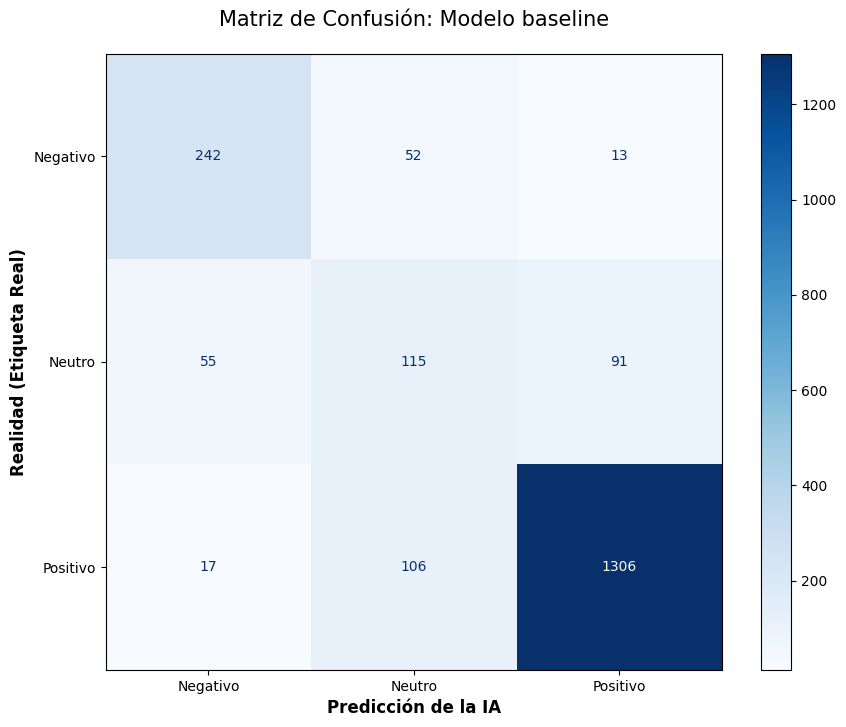

/tmp/ipykernel_64707/3315092381.py:27: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) DejaVu Sans.
  fig.savefig(ruta_final, dpi=300, bbox_inches='tight')


✅ Gráfico con timestamp guardado: ../data/results/graph/01_baseline_matriz_validation_20251222_1534.png


In [45]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# 1. Generar predicciones con el pipeline optimizado
y_pred = pipeline_sentimiento.predict(X_val_text)

# 2. Imprimir el reporte de clasificación (texto)
print("📊 REPORTE DE CLASIFICACIÓN OPTIMIZADO (LinearSVC + N-grams)")
print("-" * 60)
print(classification_report(y_val, y_pred))

# EXTRA: Guardar el reporte de texto en un archivo
# Generas el reporte en una variable
reporte_baseline = classification_report(y_val, y_pred)

# Lo exportas con un nombre claro
exportar_reporte(reporte_baseline, "01_baseline_training_report")

# 3. Configurar y mostrar la Matriz de Confusión
fig_base, ax = plt.subplots(figsize=(10, 8))

# Usamos 'Blues' para mantener la estética que solicitaste
# El parámetro 'values_format='d'' asegura que los números se vean como enteros
ConfusionMatrixDisplay.from_predictions(
    y_val, 
    y_pred, 
    display_labels=pipeline_sentimiento.classes_, 
    cmap='Blues', 
    ax=ax,
    values_format='d'
)

plt.title('Matriz de Confusión: Modelo baseline', fontsize=15, pad=20)
plt.xlabel('Predicción de la IA', fontsize=12, fontweight='bold')
plt.ylabel('Realidad (Etiqueta Real)', fontsize=12, fontweight='bold')
plt.grid(False) # Quita las líneas de cuadrícula para que el mapa de calor sea limpio
plt.show()

# EXPORTAR GRÁFICA
exportar_grafico(fig_base, '01_baseline_matriz_validation')

_"Aunque el modelo actual presenta un rendimiento sólido (85% Accuracy y 81% Recall en Negativos), procederemos a realizar un ajuste fino de hiperparámetros mediante GridSearchCV para intentar optimizar la detección de la clase Neutra y maximizar la precisión global."_

# Optimizacion

## Ajuste fino del modelo (Fine-tuning) para maximizar el rendimiento
Estamos utilizando una técnica llamada Validación Cruzada (**Cross-Validation**) combinada con **Grid Search**.

- **Grid Search (Búsqueda de Grilla):** 
Definimos una "malla" de valores posibles para `C` (la regularización) y para el `vectorizador`. </br>
El código probará todas las combinaciones posibles (como un candado de combinación) hasta encontrar la que mejor funcione.

- **Cross-Validation (CV):** 
Para no depender de la "suerte" de un solo split, el modelo divide el set de entrenamiento en 5 partes (folds). </br>
Entrena en 4 y prueba en 1, rotando el proceso 5 veces. Esto asegura que el resultado sea robusto y no un espejismo.

In [13]:
from sklearn.model_selection import GridSearchCV

# 1. Definimos el espacio de búsqueda
# 'tfidf__' y 'clf__' se refieren a los nombres que pusimos en el Pipeline

param_grid = {
    'tfidf__max_features': [3000, 5000], # ¿Es mejor aprender 3k o 5k palabras/bigramas?
    'clf__C': [0.1, 0.5, 1, 10],         # Probamos diferentes niveles de rigidez
    'clf__loss': ['hinge', 'squared_hinge'] # Probamos las dos funciones de pérdida
}

# 2. Configuramos el buscador
# Usamos scoring='f1_macro' para que el modelo se esfuerce por mejorar los Neutros y Negativos

grid_search = GridSearchCV(
    pipeline_sentimiento, 
    param_grid, 
    cv=5, 
    scoring='f1_macro', 
    n_jobs=-1, 
    verbose=1
)

# 3. Ejecutamos la búsqueda (esto puede tardar un minuto)
print("⏳ Buscando la mejor combinación de parámetros...")
grid_search.fit(X_train_text, y_train)

# 4. Resultados
print(f"\n✅ Mejores parámetros: {grid_search.best_params_}")
print(f"Mejor puntuación F1-Macro: {grid_search.best_score_:.4f}")

⏳ Buscando la mejor combinación de parámetros...
Fitting 5 folds for each of 16 candidates, totalling 80 fits

✅ Mejores parámetros: {'clf__C': 0.1, 'clf__loss': 'squared_hinge', 'tfidf__max_features': 5000}
Mejor puntuación F1-Macro: 0.7452


## Reporte de clasificacion con modelo optimizado

🏆 REPORTE DE CLASIFICACIÓN FINAL (Modelo Optimizado)
------------------------------------------------------------
              precision    recall  f1-score   support

    Negativo       0.80      0.81      0.80       307
      Neutro       0.45      0.57      0.50       261
    Positivo       0.95      0.90      0.92      1429

    accuracy                           0.84      1997
   macro avg       0.73      0.76      0.74      1997
weighted avg       0.86      0.84      0.85      1997

✅ Reporte guardado: ../data/results/reports/02_optimized_validation_report_20251222_1534.txt


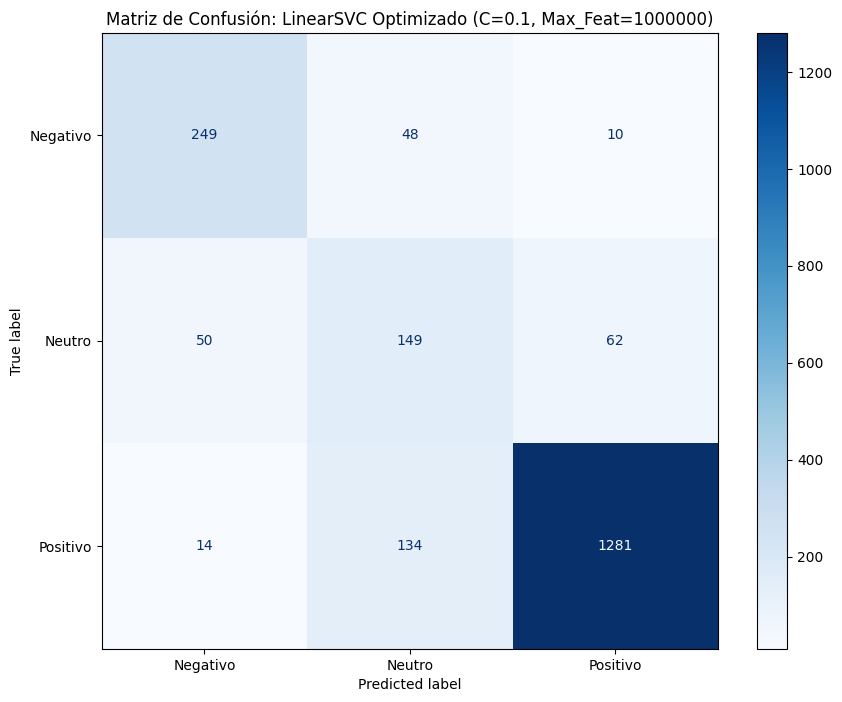

/tmp/ipykernel_64707/3315092381.py:27: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) DejaVu Sans.
  fig.savefig(ruta_final, dpi=300, bbox_inches='tight')


✅ Gráfico con timestamp guardado: ../data/results/graph/02_optimization_matriz_validation_20251222_1534.png


In [44]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. Obtenemos el mejor modelo directamente del buscador
# El objeto grid_search ya tiene guardada la mejor configuración
mejor_modelo_final = grid_search.best_estimator_

# 2. Realizamos la predicción final sobre el set de VALIDACIÓN
y_pred_final = mejor_modelo_final.predict(X_val_text)

# 3. Imprimimos el Reporte de Clasificación Definitivo
print("🏆 REPORTE DE CLASIFICACIÓN FINAL (Modelo Optimizado)")
print("-" * 60)
print(classification_report(y_val, y_pred_final))

# EXTRA: Guardar el reporte de texto en un archivo
reporte_val = classification_report(y_val, y_pred_final)
# Generas el reporte en una variable
exportar_reporte(reporte_val, "02_optimized_validation_report")

# 4. Matriz de Confusión Final
fig, ax = plt.subplots(figsize=(10, 8))
ConfusionMatrixDisplay.from_predictions(
    y_val, 
    y_pred_final, 
    display_labels=mejor_modelo_final.classes_, 
    cmap='Blues', 
    ax=ax,
    values_format='d'
)
plt.title('Matriz de Confusión: LinearSVC Optimizado (C=0.1, Max_Feat=1000000)')
plt.grid(False)
plt.show()

# EXPORTAR GRÁFICA
exportar_grafico(fig, '02_optimization_matriz_validation')


Se experimentó posteriormente con una configuración de alta dimensionalidad (100k features y tri-gramas), pero se determinó que el modelo de 5,000 features con bi-gramas ofrece una mejor generalización (F1-Macro de 0.7362). El exceso de características introdujo ruido, confirmando que para este volumen de datos, la estructura de segundo orden es el punto óptimo de equilibrio

# Evaluacion Conjunto Prueba `X_test_text`
Usa el mejor modelo encontrado para predecir las etiquetas del conjunto de prueba que reservaste al principio.

=== TEST DATASET REPORT (UNSEEN DATA) ===
              precision    recall  f1-score   support

    Negativo       0.78      0.83      0.81       307
      Neutro       0.45      0.56      0.50       261
    Positivo       0.94      0.89      0.91      1429

    accuracy                           0.84      1997
   macro avg       0.73      0.76      0.74      1997
weighted avg       0.85      0.84      0.84      1997

✅ Reporte guardado: ../data/results/reports/03_unseen_data_final_report_20251222_1539.txt


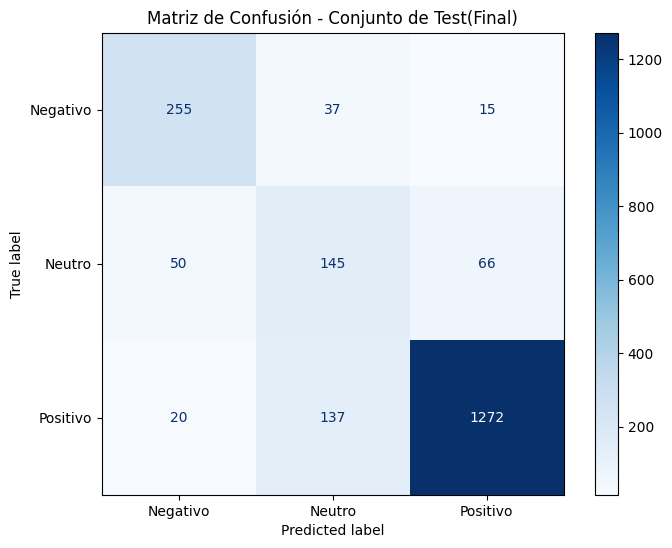

✅ Gráfico con timestamp guardado: ../data/results/graph/03_final_unseen(test)_matrix_validation_20251222_1539.png


/tmp/ipykernel_64707/3315092381.py:27: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) DejaVu Sans.
  fig.savefig(ruta_final, dpi=300, bbox_inches='tight')


In [47]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# 1. Generar predicciones con el mejor modelo del GridSearch
y_pred_test = grid_search.best_estimator_.predict(X_test_text)

# 2. Imprimir el Reporte de Clasificación en texto
print("=== TEST DATASET REPORT (UNSEEN DATA) ===")
print(classification_report(y_test, y_pred_test))

# Generas el reporte en una variable
reporte_test = classification_report(y_test, y_pred_test)
# Lo exportas con un nombre claro
exportar_reporte(reporte_test, "03_unseen_data_final_report")

# 3. Graficar la Matriz de Confusión con tonos azules
fig_test, ax = plt.subplots(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_test)

# Usamos ConfusionMatrixDisplay para el estilo y cmap='Blues' para los tonos
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_search.classes_)
disp.plot(cmap='Blues', ax=ax, values_format='d')

plt.title('Matriz de Confusión - Conjunto de Test(Final)')
plt.grid(False) # Quitar líneas de grid que a veces pone seaborn/matplotlib
plt.show()

# EXPORTAR GRÁFICA 3
exportar_grafico(fig_test, '03_final_unseen(test)_matrix_validation')

# Exportacion de objetos

## Funcion de exportacion (Joblib)

In [54]:
import joblib
import os

def exportar_modelo_joblib(modelo, nombre_base):
    """
    Guarda el modelo/pipeline usando joblib en la carpeta de modelos.
    """
    # 1. Definir y crear ruta
    output_dir = '../data/models/'
           
    # 2. Definir nombre con extensión .pkl (compatible con la mayoría de APIs)
    ruta_final = os.path.join(output_dir, f"{nombre_base}.pkl")
    
    # 3. Guardar con compresión (3 es un buen equilibrio entre velocidad y tamaño)
    joblib.dump(modelo, ruta_final, compress=3)
    
    print(f"💾 Modelo optimizado guardado con Joblib en: {ruta_final}")

## Exportacion modelo `Champion`

In [55]:

# Usamos el objeto 'mejor_modelo_final' que definiste antes
exportar_modelo_joblib(mejor_modelo_final, 'modelo_sentimiento_pipeline')

# Nota para el equipo de Backend:
# Para cargar este modelo en la API deben usar:
# import joblib
# modelo = joblib.load('../data/models/modelo_sentimiento_pipeline.pkl')

💾 Modelo optimizado guardado con Joblib en: ../data/models/modelo_sentimiento_pipeline.pkl


## Extraccion y exportacion de vectorizador

In [56]:
import joblib
import os

# 1. Extraer el vectorizador del pipeline entrenado
# Usamos .named_steps para acceder al componente específico
vectorizador_entrenado = mejor_modelo_final.named_steps['tfidf']

# 2. Definir la ruta en la carpeta 'processing'
output_dir_proc = '../data/processing/'
if not os.path.exists(output_dir_proc):
    os.makedirs(output_dir_proc)

ruta_vectorizador = os.path.join(output_dir_proc, 'vectorizador_tfidf.pkl')

# 3. Guardar con Joblib
joblib.dump(vectorizador_entrenado, ruta_vectorizador, compress=3)

print(f"📦 Vectorizador extraído y guardado en: {ruta_vectorizador}")

📦 Vectorizador extraído y guardado en: ../data/processing/vectorizador_tfidf.pkl
